# CONTOUR MASKING

using [hull of] biggest contour

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
def closeCnt(image2close):
    kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
    image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
    image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
    kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
    image2close=cv.dilate(image2close,kernel,iterations=2)
    kernel = np.ones((15,15),np.uint8)
    image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
    return image2close

def roiHud(image2hud,cnt2hud,hull2hud):
    # draw max contour
    cv.drawContours(image2hud, cnt2hud, -1,(25,205,255), 10)
    
    # draw convex hull
    cv.drawContours(image2hud, [hull2hud], -1, (255, 255, 0), 5)

    # rotated rect 
#     rect = cv.minAreaRect(cnt2hud)
#     box = np.int0(cv.boxPoints(rect))
#     cv.drawContours(image2hud, [box], 0, (0,0,255), 8)

    # bounding rect and center
    xR,yR,wR,hR = cv.boundingRect(cnt2hud)
    cv.rectangle(image2hud, (xR,yR), (xR+wR,yR+hR), (255,0,255), 5)

    # rectangle center
    xcR,ycR=xR+wR//2, yR+hR//2
    cv.circle(image2hud, (xcR,ycR), 15, (0,255,0), 18)
    
    return image2hud, (xcR, ycR),(wR,hR)
print('done')

done


In [2]:
# image to find contour and roi
##result of previous code coventiently modified as if robot not present
foreground=cv.imread('../../images/panel/panel_real.jpg')
h,w,_=foreground.shape
##center for alignment pourposes, in foreground coord.
co=(w//2,h//2)

# image to print, POV camera video stream simulation
sourceimg=cv.imread('../../images/marsyard/task_newnew.jpg')
##sourceimg could be a frame extracted from the video stream
sourcecopy=sourceimg.copy()

#foreground=bgForeImprov(foreground)

# foreground grayscaling and binarization
imgcnts = cv.cvtColor(foreground, cv.COLOR_BGR2GRAY)
#imgtrack = cv.threshold(bpMask,10,255,0)#, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
imgcnts[imgcnts<10]=0
imgcnts[imgcnts>=10]=255

#imgcnts=cv.Canny(imgcnts,120,60)
## canny's edges do not appear to improve the contour closing results

# close max contour
# imgcnts=closeCnt(imgcnts)

# contours
cnts = cv.findContours(imgcnts, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
##contours closing possible also after, test didn't work

# max contour, hull and hullmask
maxcnt=max(cnts, key=len)
#_maxcnt=max(cnts, key=lambda x: cv.contourArea(x)) ##alternatively
hullmax=cv.convexHull(maxcnt)
#hullMask=cv.cvtColor(cv.fillConvexPoly(np.zeros(foreground.shape,np.uint8),hullmax,255),cv.COLOR_BGR2GRAY)
hullMask=cv.fillConvexPoly(np.zeros((h,w),np.uint8),hullmax,255)

# FOREGROUND

# masked foreground image
foreground=cv.bitwise_and(foreground,foreground,mask=hullMask)

# image with roi highlight and center
forehud,rco,(wr,hr)=roiHud(sourceimg,maxcnt,hullmax)
##paneltask_real: rco=(370, 621), hr=1013, wr=705
##     paneltask: rco=(388, 609), hr=995 , wr=671

# ROI center in foreground coordinates
rcox,rcoy=rco
# roi dimensions
# wr, hr
##dimensions to construct the fake background

# toggles clean input without hud
freshInput=1
if freshInput:
    forehud=sourcecopy
    #cv.circle(forehud, (rco), 15, (0,255,0), 14)

# displaying
if 0:  
    plt.figure(figsize=(20,10))
    plt.imshow(cv.cvtColor(forehud,cv.COLOR_BGR2RGB))
    plt.title('roi highlighting') if not(freshInput) else plt.title('clean input')
    plt.show()
    plt.figure(figsize=(20,10))
    plt.imshow(cv.cvtColor(foreground,cv.COLOR_BGR2RGB))
    plt.title('masked image as feeded to algorithm')
    plt.show()

print('done')

done


# MOTION  SIMULATION

can toggle between video recording or frame display;



In [3]:

# MOTION PARAMETERS
# robot traverse action (simulation by moving the image, macrostep)
motx=motx0=70
moty=moty0=0
# traverse action divided in steps €[1,motx] (for graphical reasons, microstep) 
stepx=stepx0=13
stepx=motx0 if stepx0>motx0 else (1 if stepx0<1 else stepx0)
##effective motion is of motx entity, which is performed in stepx entity steps

# motion termination criterion, by roi and POV center distance
epsx=0
if epsx<0: epsz=0
# motion action dimming test array 
motestx=[]
    
# BACKGROUND 
##result of masking the camera POV, big enough to center each possible roi
## height depending on max nearess robot will approach the panel
H,W=2*h+moty0,w*2+motx0
##leave h to have video size of foreground image, but roi center won't be centered
background=np.zeros((H,W,3),np.uint8)
# center in POV coord.
CO=(W//2+1+motx0//2,H//2+moty0//2)
##incremented of 1 for graphical purposes



# IMAGE CENTERS GEOMETRY
# rcC= rcO-CO=rco+oO-CO
## rcC: POV center-ROI center; to minimize
## rcO: roi center in POV coord.
## CO: background center in POV coord.
## oO: foreground origin in POV coord.

# starting position of foreground in POV camera

oO=(oOx,oOy)=(oOx0,oOy0)=(0,CO[1]-rcoy)
##oO0y s.t. aligns vertically POV and ROI center, supposing similar vertical aligning system as well
##oO0x arbitrary
#_add random position with test on possible casting foreground image in background shape

##addiotional geometries
# rcO=roO+rcro
## roO: roi origin in POV coord.
## rcro: roi center in ROI coord.== (wr/2,hr/2); const
# roO=roo+oO
## roo: roi origin in FOREGROUND coord.; const
    


    
# FRAME EXTENSION
# extends the output height of this many pixel wrt roih
exthr=100
if exthr<0: exthr= 0

# extended hull mask
extHullMask=np.zeros((H,W),np.uint8)
extHullMask[oOy0:oOy0+h,oOx0:oOx0+w]=hullMask
extHullMask=extHullMask[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

extforeground=np.zeros((H,W,3),np.uint8)
extforeground[oOy0:oOy0+h,oOx0:oOx0+w]=cv.imread('../../images/marsyard/task_newnew.jpg')
extforeground=extforeground[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

# apply extended hullMask
if 0:
    extforeground=cv.bitwise_and(extforeground,extforeground,mask=extHullMask)
# write result
if 0:
    cv.imwrite('../../images/panel/extended/',extforeground)

#############
print('done')

done


In [ ]:
# toggle printing of information
togglePrint=1

# toggles video recording
vidRecNoPrint=0

# toggles image plotting 
plotNoRec=0 if vidRecNoPrint else 1
##change last one only

# toggles storing of first output image
click=0
if click:clickimage=[]

# OUTPUT AND VIDEO RECORDING   
if vidRecNoPrint:
#     empty video array and frame dimensions
    video_array = []
    videoH,videoW=hr+exthr,W
    video_size =(videoW,videoH)
    COneo=video_size//2
    #_adapt width to starting initial conditoin for foreground
    
if togglePrint:print('video recording started') if vidRecNoPrint else print('motion starting')
    
# MOTION
while(1):##actually a do-while
    
    # geometric referencing
    rcO=[sum(jj) for jj in zip(rco, oO)]##increasing
    rcC=rcCx,rcCy=[sum(jj) for jj in zip(CO, np.negative(rcO))]
    ##rcCx>0 if roi center on POV center's left
    if togglePrint:print('rcO',rcO,'rcC',rcC,'CO ',CO,'oO ',oO)
    
    # ACTUATION CONTROL
    # test array accumulation
    motestx.append(rcCx)
    # accumulation stop criterion
    if len(motestx)>2:
        # remove oldest stored position
        motestx.pop(0)
        if motestx[0]*motestx[1]<0:
            # traverse action dimming
            motx=motx//2
            if stepx>1: stepx=stepx//2
            if togglePrint:print('oscilaltions along x!horizontal speed reduction')
            #_may modify in motion proportional to distance, ie K control
       
    # MOTION ACTUATION
    # motion direction detection
    actualx=stepx if rcCx>0 else -stepx   
    # motion steps performance
    for count in range(0,motx,stepx):
        # creation of a new empty background
        backprint=background.copy()
        # foreground insertion
        backprint[oOy:oOy+h,oOx:oOx+w]=forehud
        # POV center marker
        cv.circle(backprint,CO,32,(0,0,255),16)
        
        # output simmetric wrt roi center
        motOutput=backprint[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]
        if click: clickimage=motOutput;click=0
        # output redirection
        if vidRecNoPrint:
            video_print=motOutput
            video_array.append(video_print)
        elif plotNoRec:
            plt.figure(figsize=(20,10))
            plt.imshow(cv.cvtColor(motOutput,cv.COLOR_BGR2RGB))
#             plt.imshow(cv.cvtColor(motOutput[:,min(rcO[0]-wr//2,CO[0]-wr//2):\
#                    max(rcO[0]+wr//2,CO[0]+wr//2)],cv.COLOR_BGR2RGB))
            plt.show()
     
        # motion of foreground position toward center
        oO=oOx,oOy=oOx+actualx,oOy
        
        
    # MOTION TERMINATION        
    # motion termination test on distance roi center-POV center
    if abs(rcCx)<=epsx:
        # reset traverse actions for future requests
        motx=motx0
        stepx=stepx0
        if not vidRecNoPrint and togglePrint:print('terminating motion along x...')
        # interrupts action
        break
        
    if togglePrint: print('### moving ###')
        
if togglePrint: print('__motion terminated__') 

# video memorization
if vidRecNoPrint:
    # video object
    video_out = cv.VideoWriter('../../images/video/video_task.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, video_size) 
    # replicates each frame this number of times
    clonedFrames=0
    if clonedFrames>0:
        # frames cloning
        video_array2=[ii for ii in video_array for jj in range(clonedFrames+1)]
        # frames array writen in video object
        for ii in video_array2: video_out.write(ii)
    else:
        for ii in video_array: video_out.write(ii)
            
    video_out.release()

    print('video recording terminated')
print('done')

#### simulation of robot approaching the panel

https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/

https://pythonexamples.org/python-opencv-cv2-resize-image/

https://stackoverflow.com/questions/4195453/how-to-resize-an-image-with-opencv2-0-and-python2-6



#### traversing function

omitted since can't work properly by printing motions steps

In [ ]:
# # def moTraverse(xmotion,xstep,xdist,framedist,imgbackground,imgforeground,roih)
# #     MOTION PERFORMANCE
    
# #     motion direction detection
#     actualx=xstep if xdist>0 else -xstep  
# #     motion steps performance
#     for count in range(0,xmotion,xstep):
#         if xstep!=xmotion:print('step ',count,'/',xmotion) 
# #         motion of foreground position toward center
#         framedist=framedistx,framedisty=framedist[0]+actualx,framedist[1]
# #         creation of a new empty background
#         imgbackprint=imgbackground.copy()
# #         foreground insertion
#         foregroundh,foregroundw,_=imgforeground.shape
#         imgbackprint[framedisty:framedisty+foregroundh,\
#                      framedistx:framedistx+foregroundw]=imgforeground
# #         POV center marker
#         ,_=list(reversed())
#         _,aax,aay=_,*backgroundCenter=np.floor_divide(list(reversed(imgbackground.shape)),2)
#         cv.circle(imgbackprint,backgroundCenter,40,(0,0,255),20)
        
#         outputImage=backprint[backgroundCenter[1]-(roih//2):backgroundCenter[1]+roih//2,:]
#     return framedist,outputImage
    
# oO,outputimage=(oOx,oOy),motOutput=moTraverse(motx,stepx,rcCx,oO,)
# #         output redirection
# if toggleVideoRec:
#     video_print=motOutput
#     video_array.append(video_print)
# else:
# #     print('rcCx ',rcCx,',motestx ',motestx,', stepx ',stepx)#debug
#     plt.imshow(cv.cvtColor(motOutput,cv.COLOR_BGR2RGB))
# #     plt.imshow(cv.cvtColor(motOutput[:,min(rcO[0]-wr//2-5,CO[0]-wr//2-5):\
# #            max(rcO[0]+wr//2+5,CO[0]+wr//2+5)],cv.COLOR_BGR2RGB))
#     plt.show()    


# FOREGROUND TRACKING

using camshift

In [13]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# video loading
videosrc='../../images/video/task_ext.avi'
cap = cv.VideoCapture(videosrc)
# setup initial location of window
if cap.isOpened():
    ret, frame = cap.read()
#else: cap.release()

# roi upper left vertex
roix,roiy=rcox-wr//2,exthr//2
# tracking window
trackWin = (roix,roiy, roix+wr,roiy+hr)
# ROI for tracking and histograms
# as extracted from the video
roiVidh=cv.cvtColor(frame[roiy:roiy+hr,roix:roix+wr],cv.COLOR_BGR2HSV)
roiSmallh=cv.cvtColor(frame[roiy+hr//4:roiy+3*hr//4,roix+wr//4:roix+3*wr//4],cv.COLOR_BGR2HSV)
# as taken from masking result
roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

##histMasked=cv.calcHist([roiMaskedh],[0,1],None,[180,256],[0,180,0,256]) 
##equivalent to:
#histroieq1=cv.calcHist([cv.cvtColor(extforeground,cv.COLOR_BGR2HSV)],[0,1],extHullMask,[179,255],[1,180,1,256])
#histroieq2=cv.calcHist([cv.cvtColor(foreground,cv.COLOR_BGR2HSV)],[0,1],hullMask,[179,255],[1,180,1,256])
roiLib=(roiVidh,roiSmallh,roiMaskedh)
roi_select=roiLib[0]

HchanOnly=1
h_bins = 179
s_bins = 255
histSize = [h_bins] if HchanOnly else [h_bins, s_bins]
h_ranges = [0, 180] 
if not HchanOnly:s_ranges = [0, 256]
ranges = h_ranges  if HchanOnly else h_ranges+ s_ranges
channels = [0] if HchanOnly else [0, 1]


histroi=cv.calcHist([roi_select],channels,None,histSize,ranges)
cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

doMeanShift=1
while(1):
    ret, frame = cap.read()
    
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        
        dst = cv.calcBackProject([hsv],[0],histroi,[0,180],1)
        
        if doMeanShift:
            # apply meanshift to get the new location
            ret, trackWin = cv.meanShift(dst, trackWin, term_crit)
            # Draw it on image
            x,y,w,h = trackWin
            img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        else:
            # apply camshift to get the new location
            ret, trackWin = cv.CamShift(dst, trackWin, term_crit)
            # Draw it on image
            pts = cv.boxPoints(ret)
            pts = np.int0(pts)
            img2 = cv.polylines(frame,[pts],True, 255,2)
        cv.imshow('img2',img2)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
   
print('done')

KeyboardInterrupt: 

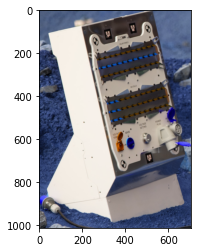

ValueError: operands could not be broadcast together with shapes (1013,704,3) (1012,704,3) 

In [19]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# video loading
videosrc='../../images/video/task_ext.avi'
cap = cv.VideoCapture(videosrc)
# setup initial location of window
if cap.isOpened():
    ret, frame = cap.read()
else: cap.release()
##roi in foreground coord (unextended) foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2]
##roi in extended coord     frame[exthr//2:exthr//2+hr,rcox-wr//2:rcox+wr//2]
plt.imshow(forehud[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2])
plt.show()
plt.imshow(frame[exthr//2:exthr//2+hr,rcox-wr//2:rcox+wr//2]-forehud[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2])
plt.show()
# # toggle use of small tracking window (halved width and height)
# smallWin=1

# #small
# if smallWin:
#     roix,roiy=rcox-wr//4,exthr//2+hr//4
#     roih,roiw=hr//2,wr//2
# else:
#     #regular
#     roix,roiy=rcox-wr//2,exthr//2
#     roih,roiw=hr,wr
# trackWin=(roix,roiy,roix+roiw,roiy+roih)

# # ROI for tracking and histograms
# # as extracted from the video
# # roiVidh=cv.cvtColor(frame[roiy:roiy+roih,roix:roix+roih],cv.COLOR_BGR2HSV)
# roiVidh=frame[roiy:roiy+roih,roix:roix+roih]
# #roiSmallh=cv.cvtColor(frame[roiy+hr//4:roiy+3*hr//4,roix+wr//4:roix+3*wr//4],cv.COLOR_BGR2HSV)
# # as taken from masking result
# # roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)
# roiMaskedh=foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy()
# ##histMasked=cv.calcHist([roiMaskedh],[0,1],None,[180,256],[0,180,0,256]) 
# ##equivalent to:
# #histroieq1=cv.calcHist([cv.cvtColor(extforeground,cv.COLOR_BGR2HSV)],[0,1],extHullMask,[179,255],[1,180,1,256])
# #histroieq2=cv.calcHist([cv.cvtColor(foreground,cv.COLOR_BGR2HSV)],[0,1],hullMask,[179,255],[1,180,1,256])
# roiLib=(roiVidh,roiMaskedh)
# roi_select=roiLib[1]

In [15]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# video loading
videosrc='../../images/video/task_ext.avi'
cap = cv.VideoCapture(videosrc)
# setup initial location of window
if cap.isOpened():
    ret, frame = cap.read()
#else: cap.release()

# toggle use of small tracking window (halved width and height)
smallWin=0
# roi upper left vertex
if smallWin:roix,roiy=rcox-wr//4,exthr//2+hr//4
else: roix,roiy=rcox-wr//2,exthr//2
# tracking window
trackWin = (roix,roiy, roix+wr//2,roiy+hr//2) if smallWin else (roix,roiy, roix+wr,roiy+hr)

# ROI for tracking and histograms
# as extracted from the video
roiVidh=cv.cvtColor(frame[roiy:roiy+hr,roix:roix+wr],cv.COLOR_BGR2HSV)
roiSmallh=cv.cvtColor(frame[roiy+hr//4:roiy+3*hr//4,roix+wr//4:roix+3*wr//4],cv.COLOR_BGR2HSV)
# as taken from masking result
roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

##histMasked=cv.calcHist([roiMaskedh],[0,1],None,[180,256],[0,180,0,256]) 
##equivalent to:
#histroieq1=cv.calcHist([cv.cvtColor(extforeground,cv.COLOR_BGR2HSV)],[0,1],extHullMask,[179,255],[1,180,1,256])
#histroieq2=cv.calcHist([cv.cvtColor(foreground,cv.COLOR_BGR2HSV)],[0,1],hullMask,[179,255],[1,180,1,256])
roiLib=(roiVidh,roiSmallh,roiMaskedh)
roi_select=roiLib[1]

HchanOnly=0
h_bins = 180
s_bins = 256
histSize = [h_bins] if HchanOnly else [h_bins, s_bins]
h_ranges = [0, 180] 
if not HchanOnly:s_ranges = [0, 256]
ranges = h_ranges  if HchanOnly else h_ranges+ s_ranges
channels = [0] if HchanOnly else [0, 1]


histroi=cv.calcHist([roi_select],channels,None,histSize,ranges)
cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 100, 1 )

doMeanShift=1
while(1):
    ret, frame = cap.read()
    
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        
        dst = cv.calcBackProject([hsv],channels,histroi,ranges,1)
        
        if doMeanShift:# doMeanShift:
            # apply meanshift to get the new location
            ret, trackWin = cv.meanShift(dst, trackWin, term_crit)
            # Draw it on image
            x,y,w,h = trackWin
            img2 = cv.rectangle(frame, (x,y), (x+w,y+h), (0,255,0),2)
#         else:
#             # apply camshift to get the new location
#             ret, trackWin = cv.CamShift(dst, trackWin, term_crit)
#             # Draw it on image
#             pts = cv.boxPoints(ret)
#             pts = np.int0(pts)
#             img2 = cv.polylines(frame,[pts],True, 255,2)
        cv.imshow('img2',img2)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
   
print('done')

KeyboardInterrupt: 